# Import des jeux de données 

In [1]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 7.8 MB/s 
     |████████████████████████████████| 76 kB 4.6 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=91d8e92e9d57756394638f9dbbc21eabe379bb133b74bb93fa7ebb3c2defc4fd
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.0 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 

In [2]:
pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 8.9 MB/s 


In [ ]:
import pandas as pd
import datetime
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import warnings
import statistics
from lifelines import KaplanMeierFitter
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.model_selection import train_test_split, RepeatedKFold
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.exceptions import FitFailedWarning
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

In [ ]:
# import des tables
scen2=[]
Nsim=100
folder_path = 'drive/MyDrive/scen2/'
file_list = glob.glob(folder_path + "/*.csv")
for file in file_list:
  scen2_data = pd.read_csv(file)
  scen2.append(scen2_data)

# Taux de censure

In [ ]:
# extrait des tables avant temps et statut vital
y=[]
for k in range(len(scen2)):
  scen2[k] = scen2[k].rename(columns = {'y': 'days'})
  vector_y = scen2[k].iloc[:,50:52]
  y.append(vector_y)

In [ ]:
# Comptage du nombre de vivant et mort pour chaque jeux de données
décès = []
vivant = []

for tab in y:
  d1=tab["failed"].value_counts()[1]
  décès.append(d1)
  d2=tab["failed"].value_counts()[0]
  vivant.append(d2)

print(f"Pour chaque jeux de données, nous avons calculé le nombre de mort et le nombre de vivant, nous trouvons respectivement \n "
      f"{décès} et \n {vivant}")

Pour chaque jeux de données, nous avons calculé le nombre de mort et le nombre de vivant, nous trouvons respectivement 
 [991, 980, 985, 987, 985, 992, 999, 977, 1003, 999, 990, 989, 1003, 989, 1028, 996, 1017, 1021, 964, 1009, 995, 978, 1001, 990, 999, 1028, 973, 1002, 989, 981, 1002, 1004, 1049, 1016, 977, 995, 1034, 992, 969, 956, 1015, 1004, 992, 1003, 999, 1001, 1021, 987, 933, 952, 1028, 1005, 978, 952, 1036, 993, 970, 1029, 1036, 1029, 1008, 1039, 1016, 977, 994, 1002, 949, 1009, 977, 985, 958, 1018, 1032, 1012, 968, 960, 931, 1076, 976, 958, 975, 1037, 1041, 1028, 1057, 999, 1017, 968, 953, 1003, 1038, 1024, 991, 966, 1016, 997, 1009, 1020, 967, 1039] et 
 [4009, 4020, 4015, 4013, 4015, 4008, 4001, 4023, 3997, 4001, 4010, 4011, 3997, 4011, 3972, 4004, 3983, 3979, 4036, 3991, 4005, 4022, 3999, 4010, 4001, 3972, 4027, 3998, 4011, 4019, 3998, 3996, 3951, 3984, 4023, 4005, 3966, 4008, 4031, 4044, 3985, 3996, 4008, 3997, 4001, 3999, 3979, 4013, 4067, 4048, 3972, 3995, 4022, 4048, 39

In [ ]:
# taux de censure
tx_censures=[]
N=5000 #effectif 
for nb_vivant in range(len(vivant)):
  tx_censure = vivant[nb_vivant]/N
  tx_censures.append(tx_censure)

print(f"{statistics.mean(tx_censures)}+-{statistics.stdev(tx_censures)}")

0.800426+-0.005448058128703971


# Modélisation

## Cox sans sélection de variable 

In [ ]:
# extraire les y et les transformer en dnarray
y2=[0 for k in range(len(y))]
aux=[0 for k in range(len(y))]
new_y=[0 for k in range(len(y))]
for k in range(len(y)):
  y[k] = y[k].reindex(columns=["failed", "days"])
  y2[k]=y[k].to_numpy()
  aux[k] = [(e1,e2) for e1,e2 in y2[k]]
  new_y[k] = np.array(aux[k], dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
new_y[0]

array([( True,  97.), (False, 100.), (False,  56.), ..., (False,   1.),
       ( True, 100.), ( True,  54.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [ ]:
X=[0 for i in range(len(scen2))]
for x in range(len(scen2)):
  X[x] = scen2[x].iloc[:,0:50]

In [ ]:
# coefficient des variables dans le modèle sans sélection de variables 
estimator = CoxPHSurvivalAnalysis()
list_coef = [] # on stocke la liste des coefficients de chaque modèle pour chaque dataframe
coef_statin = [] # on stocke tous les coefficients de la variable X_statin pour chaque dataframe
for data in range(len(scen2)):
  estimator.fit(X[data], new_y[data])
  coef_statin.append(estimator.coef_[0])
  list_coef.append(estimator.coef_)

## Cox avec sélection de variable (via pénalité de Lasso)

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [ ]:
list_cox_estimator = [ make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)) for k in range(Nsim)]


In [ ]:
# Choix de la valeur de alpha pour le Lasso
# Utilisation de l'échantillon d'alphas et performance sur 5 blocs pour la validation croisée avec la métrique du C-index pour chaque alpha

list_estimated_alphas_lasso=[]
list_gcv_lasso=[]
for i in range(Nsim):
  list_cox_estimator[i].fit(X[i], new_y[i])
  list_estimated_alphas_lasso.append(list_cox_estimator[i].named_steps["coxnetsurvivalanalysis"].alphas_)
  cv_lasso = KFold(n_splits=5, shuffle=True, random_state=0)
  list_gcv_lasso.append(GridSearchCV(
    list_cox_estimator[i],
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in list_estimated_alphas_lasso[i]]},
    cv=cv_lasso,
    error_score=0.5, # score utilisé par défaut
    n_jobs=4).fit(X[i], new_y[i]))
  list_gcv_lasso

In [ ]:
# évaluation des alphas dans chaque bloc pour le maximiser
list_cv_results_lasso = []
for gcv_lasso in list_gcv_lasso:
  list_cv_results_lasso.append(pd.DataFrame(gcv_lasso.cv_results_))

In [ ]:
# lister les valeurs de alphas, moyenne et std de alphas pour chaque blocs
list_alphas_lasso=[]
list_mean_lasso=[]
list_std_lasso=[]
for cv_results_lasso in list_cv_results_lasso:
  list_alphas_lasso.append(cv_results_lasso.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0]))
  list_mean_lasso.append(cv_results_lasso.mean_test_score)
  list_std_lasso.append(cv_results_lasso.std_test_score)

In [ ]:
# sélection de variable 
list_best_model_lasso = []
list_best_coefs_lasso = []
list_non_zero_lasso = []
list_non_zero_coefs_lasso = []
list_coef_order_lasso = []

for gcv_lasso in list_gcv_lasso:
  list_best_model_lasso.append(gcv_lasso.best_estimator_.named_steps["coxnetsurvivalanalysis"])

for  k in range(len(list_best_model_lasso)):
    list_best_coefs_lasso.append(pd.DataFrame(
    list_best_model_lasso[k].coef_,
    index=X[k].columns,
    columns=["coefficient"]))

# Donner le nombre de variable sélectionné pour chaque jeu de données et extraire les coefficients des variables sélectionnés 
for best_coefs_lasso in list_best_coefs_lasso:
  list_non_zero_lasso.append(np.sum(best_coefs_lasso.iloc[:, 0] != 0))
  list_non_zero_coefs_lasso.append(best_coefs_lasso.query("coefficient != 0"))

# Réordonner les variables sélectionnés par ordre croissant de leur coefficients (et cela pour chaque jeux de données)
for non_zero_coefs_lasso in list_non_zero_coefs_lasso:
  list_coef_order_lasso.append(non_zero_coefs_lasso.abs().sort_values("coefficient").index)

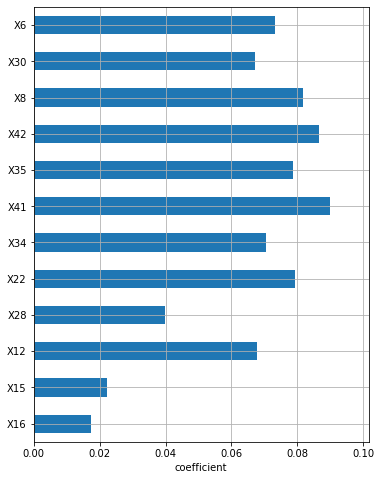

In [ ]:
# tracer les variables sélectionnées et leur coefficients
_, ax_lasso = plt.subplots(figsize=(6, 8))
list_graph_lasso = []
for non_zero_coefs_lasso, coef_order_lasso in zip(list_non_zero_coefs_lasso, list_coef_order_lasso):
  list_graph_lasso.append(non_zero_coefs_lasso.loc[coef_order_lasso].plot.barh(ax=ax_lasso, legend=False))
  ax_lasso.set_xlabel("coefficient")
  ax_lasso.grid(True)

In [ ]:
# sélectionner les modèles qui ont sélectionné X_statin et énumérer les coefficients de X_statin
list_best_coefs_lasso_statin=[]
list_coef_xstatin = []
non_zero_coefs_lasso_statin = []
for i , best_coefs_lasso in enumerate(list_best_coefs_lasso):
  list_coef_xstatin.append(best_coefs_lasso.iloc[0,0])
  non_zero_coefs_lasso_statin.append(best_coefs_lasso.query("coefficient != 0"))
  if best_coefs_lasso.iloc[0,0] !=0:
    list_best_coefs_lasso_statin.append(best_coefs_lasso)
    print(f"la table {i+1} sélectionne X_statin")
  else:
    print(f"la table {i+1} ne sélectionne pas X_statin")
print(f"Il y a en tout {len(list_best_coefs_lasso_statin)} qui sélectionne la statine.")

la table 1 ne sélectionne pas X_statin
la table 2 ne sélectionne pas X_statin
la table 3 sélectionne X_statin
la table 4 ne sélectionne pas X_statin
la table 5 ne sélectionne pas X_statin
la table 6 ne sélectionne pas X_statin
la table 7 ne sélectionne pas X_statin
la table 8 ne sélectionne pas X_statin
la table 9 ne sélectionne pas X_statin
la table 10 sélectionne X_statin
la table 11 ne sélectionne pas X_statin
la table 12 ne sélectionne pas X_statin
la table 13 ne sélectionne pas X_statin
la table 14 ne sélectionne pas X_statin
la table 15 ne sélectionne pas X_statin
la table 16 ne sélectionne pas X_statin
la table 17 ne sélectionne pas X_statin
la table 18 ne sélectionne pas X_statin
la table 19 ne sélectionne pas X_statin
la table 20 ne sélectionne pas X_statin
la table 21 ne sélectionne pas X_statin
la table 22 ne sélectionne pas X_statin
la table 23 ne sélectionne pas X_statin
la table 24 ne sélectionne pas X_statin
la table 25 sélectionne X_statin
la table 26 ne sélectionne pas

In [ ]:
non_zero_coefs_lasso_statin = []
coef_order_lasso_statin = []
for k in range(len(list_best_coefs_lasso_statin)):
  non_zero_coefs_lasso_statin.append(list_best_coefs_lasso_statin[k].query("coefficient != 0"))
  coef_order_lasso_statin.append(non_zero_coefs_lasso_statin[k].abs().sort_values("coefficient").index)

,coefficient
X_statin,0.022781
X4,0.017307
X9,0.001748
X10,0.039580
X12,0.024583
X25,0.060822
X32,0.017078
X38,0.076394


In [ ]:
# déterminer le pourcentage d'apparition et le coefficients pour chaque X_statin

## pourcentage d'apparition pour chaque X_statin 

## coefficient de chaque X_statin
list_coef_xstatin
print(f"{statistics.mean(list_coef_xstatin)}+-{statistics.stdev(list_coef_xstatin)}")

0.0006075261541345464+-0.003100621632553955


## Evaluation de la performance du modèle 

### C-index (indice de concordance)

In [ ]:
# declare the outer validation cross strategie
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

# create model
model = CoxPHSurvivalAnalysis()

# c'est là, qu'on évalue le modèle 
test_score_normal = []
for k in range(Nsim):
  test_score_normal.append(cross_val_score(model, X[k], new_y[k], cv=outer_cv, n_jobs=2))
  print(f"The mean score using nested cross-validation for the {k+1} model is: \n "
      f"{test_score_normal[k].mean():.3f} ± {test_score_normal[k].std():.3f}")

The mean score using nested cross-validation for the 1 model is: 
 0.835 ± 0.013
The mean score using nested cross-validation for the 2 model is: 
 0.784 ± 0.015
The mean score using nested cross-validation for the 3 model is: 
 0.807 ± 0.010
The mean score using nested cross-validation for the 4 model is: 
 0.840 ± 0.008
The mean score using nested cross-validation for the 5 model is: 
 0.866 ± 0.004
The mean score using nested cross-validation for the 6 model is: 
 0.833 ± 0.007
The mean score using nested cross-validation for the 7 model is: 
 0.846 ± 0.016
The mean score using nested cross-validation for the 8 model is: 
 0.858 ± 0.009
The mean score using nested cross-validation for the 9 model is: 
 0.822 ± 0.021
The mean score using nested cross-validation for the 10 model is: 
 0.821 ± 0.016
The mean score using nested cross-validation for the 11 model is: 
 0.851 ± 0.011
The mean score using nested cross-validation for the 12 model is: 
 0.843 ± 0.009
The mean score using nest

In [ ]:
for k in range(Nsim):
  print(f"Les listes de alphas optimisés sont {list(test_score_normal[k])}. \n")

Les listes de alphas optimisés sont [0.865032184778493, 0.8476393008019988, 0.8755068856144859, 0.8621765283216886, 0.8587321600745913]. 

Les listes de alphas optimisés sont [0.8572875642917646, 0.8454615108576528, 0.8567253539893759, 0.8583177638568341, 0.8542610673997535]. 

Les listes de alphas optimisés sont [0.8435727278012641, 0.8063689504545993, 0.8015855820366358, 0.834008746601827, 0.8021805830526286]. 

Les listes de alphas optimisés sont [0.8160444783527575, 0.8237352568476459, 0.8199711054828238, 0.7949875524839297, 0.8324125865085453]. 

Les listes de alphas optimisés sont [0.7975038764114418, 0.8179228643381972, 0.8053355390682441, 0.8121035894372507, 0.830032422417786]. 

Les listes de alphas optimisés sont [0.8083998673799475, 0.8200481764780458, 0.8020719226315295, 0.8148193612962928, 0.830852670724059]. 

Les listes de alphas optimisés sont [0.7361474341593122, 0.7348931689635573, 0.7497278148816198, 0.7366416178965959, 0.7595554835905608]. 

Les listes de alphas opt

***Avec pénalité de Lasso***

In [ ]:
# Declare the innercross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

cox_lasso = make_pipeline(
    CoxnetSurvivalAnalysis(l1_ratio=1.0)
)
# Inner cross-validation for parameter search
list_param_grid = []
for i in range(Nsim):
  list_param_grid.append({"coxnetsurvivalanalysis__alphas": [[v] for v in list_estimated_alphas_lasso[i]]})
# optimise les hyperparamètres
list_model_lasso = []
for j in range(Nsim):
  list_model_lasso.append(GridSearchCV(
    estimator=cox_lasso, param_grid=list_param_grid[j], cv=inner_cv, n_jobs=2
))

# Outer cross-validation to compute the testing score
# c'est là, qu'on évalue le modèle 
test_score_lasso = []
for k in range(Nsim):
  test_score_lasso.append(cross_val_score(list_model_lasso[k], X[k], new_y[k], cv=outer_cv, n_jobs=2))
  print(f"The mean score using nested cross-validation for the {k+1} model is: \n"
      f"{test_score_lasso[k].mean():.3f} ± {test_score_lasso[k].std():.3f}")

The mean score using nested cross-validation for the 1 model is: 
0.757 ± 0.013
The mean score using nested cross-validation for the 2 model is: 
0.701 ± 0.027
The mean score using nested cross-validation for the 3 model is: 
0.733 ± 0.015
The mean score using nested cross-validation for the 4 model is: 
0.729 ± 0.010
The mean score using nested cross-validation for the 5 model is: 
0.782 ± 0.014
The mean score using nested cross-validation for the 6 model is: 
0.666 ± 0.021
The mean score using nested cross-validation for the 7 model is: 
0.734 ± 0.015
The mean score using nested cross-validation for the 8 model is: 
0.781 ± 0.020
The mean score using nested cross-validation for the 9 model is: 
0.735 ± 0.016
The mean score using nested cross-validation for the 10 model is: 
0.718 ± 0.014
The mean score using nested cross-validation for the 11 model is: 
0.775 ± 0.008
The mean score using nested cross-validation for the 12 model is: 
0.745 ± 0.019
The mean score using nested cross-val

### Courbe d'apprentissage 